### Task details: 

Implement a circuit that returns |01> and |10> with equal probability (50% for each).
Requirements :

The circuit should consist only of CNOTs, RXs and RYs. 

Start from all parameters in parametric gates being equal to 0 or randomly chosen. 

You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 

Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000.

### Theory 

Starting from a |00> state we can prepare a quantum state $\frac{1}{2}$ |01> + $\frac{1}{2}$ |10> using a quantum circuit with this configuration: 

\- apply a hadmard gate (H) on the first qubit.

\- apply a not gate (X) on the second qubit. 

\- apply a CNOT gate using the first qubit as the target qubit and the second qubit as the controlled qubit. 

But in this task we are allowed to us RXs, RYs and CNOTs gates only. 

We can build a hadmard gate using RY gate by setting the theta parameter to pi/2. Also, we can build a not gate using RX gate by setting the theta parameter to pi. 

In this task, we assume we don't know these values. so we will build a varitional circuit and optimize it to get the optimal values. 


**Dependecies:**

numpy=1.18.5

qiskit=0.21.0

matplotlib=3.2.2

In [1]:
import numpy as np
from qiskit import *
import matplotlib.pyplot as plt
import qiskit.providers.aer.noise as noise
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.visualization import plot_histogram
from math import pi
%matplotlib inline

In this function we will implement our quantum circuit. 

In [2]:
def get_quantum_circuit(params): 
  quantum_register = QuantumRegister(2, name="quantum_register")
  classical_register = ClassicalRegister(2, name='classical_register')
  quantum_circuit = QuantumCircuit(quantum_register, classical_register)

  quantum_circuit.ry(params[0], quantum_register[0])
  quantum_circuit.rx(params[1], quantum_register[1])
  quantum_circuit.cx(quantum_register[0], quantum_register[1])

  quantum_circuit.measure(quantum_register, classical_register)

  return quantum_circuit

**Cost function**: 

here we define our cost function as the manhantan distance between our measured distribution from the circuit and our target distribution.

In [3]:
def get_measured_distribution(counts, num_shots): 
  measured_distribution = []
  for key in ['00', '10', '01', '11']: 
    if key in counts.keys(): 
      measured_distribution.append(counts[key]/num_shots)
    else: 
      measured_distribution.append(0)

  return np.array(measured_distribution)

def get_cost(counts, num_shots, target_distribution):
  measured_distribution = get_measured_distribution(counts, num_shots)
  cost = np.sum(np.abs(measured_distribution - target_distribution))
  return cost 


we define a noise model to add it to the simulator

In [4]:
def get_noise(): 
  prob_1 = 0.001 
  prob_2 = 0.01   

  error_1 = noise.depolarizing_error(prob_1, 1)
  error_2 = noise.depolarizing_error(prob_2, 2)

  noise_model = noise.NoiseModel()
  noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

  basis_gates = noise_model.basis_gates

  return noise_model, basis_gates

**Optimization objective function** 

In [5]:
num_shots = 1
target_distribution = np.array([0, 0.5, 0.5, 0])

def objective_function(params): 
    quantum_circuit = get_quantum_circuit(params)
    simulator_backend = Aer.get_backend("qasm_simulator")
    noise_model, basis_gates = get_noise() 
    result = execute(quantum_circuit, simulator_backend, shots=num_shots, basis_gates=basis_gates, noise_model=noise_model).result()
    cost = get_cost(result.get_counts(), num_shots, target_distribution)
    return cost

In this function we will optimize our circuit paramerters using cobyla optimizer. Then, we will try differents number of measurements.

In [6]:
def optimize_quantum_circuit():
  optimizer = COBYLA(maxiter=num_shots, tol=0.0001)

  params = [0, 0]
  params_bounds = [(0, 2*pi), (0, 2*pi)]
  results = optimizer.optimize(num_vars=2, objective_function=objective_function, initial_point=params, variable_bounds=params_bounds)

  quantum_circuit = get_quantum_circuit(results[0])
  simulator_backend = Aer.get_backend("qasm_simulator")
  counts = execute(quantum_circuit, simulator_backend, shots=num_shots).result().get_counts()
  output_distribution = get_measured_distribution(counts, num_shots)

  print("Target Distribution:", target_distribution)
  print("Last Measured Distribution:", output_distribution)
  print("Output Error (Manhattan Distance):", results[1])
  print("Parameters Found:", results[0])
  print("Number of Measurement:", num_shots)

  return counts, results[1]

1 measurements

In [7]:
losses = []
num_shots = 1
counts, loss = optimize_quantum_circuit() 
losses.append(loss)

Target Distribution: [0.  0.5 0.5 0. ]
Last Measured Distribution: [1. 0. 0. 0.]
Output Error (Manhattan Distance): 2.0
Parameters Found: [0. 0.]
Number of Measurement: 1


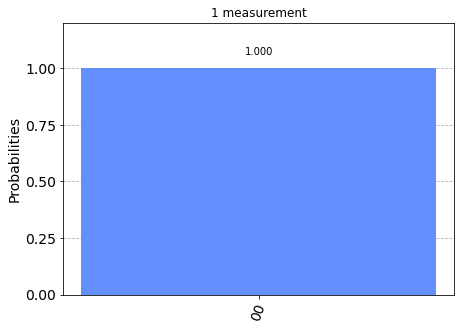

In [8]:
plot_histogram(counts, title="1 measurement")

10 measurements

In [9]:
num_shots = 10 
counts, loss = optimize_quantum_circuit() 
losses.append(loss)

Target Distribution: [0.  0.5 0.5 0. ]
Last Measured Distribution: [0.8 0.2 0.  0. ]
Output Error (Manhattan Distance): 1.2
Parameters Found: [0. 1.]
Number of Measurement: 10


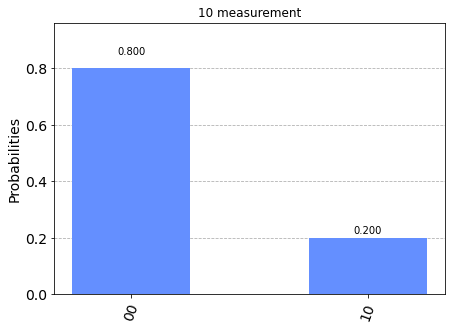

In [10]:
plot_histogram(counts, title="10 measurement")

100 measurements

In [11]:
num_shots = 100
counts, loss = optimize_quantum_circuit() 
losses.append(loss)

Target Distribution: [0.  0.5 0.5 0. ]
Last Measured Distribution: [0.   0.43 0.57 0.  ]
Output Error (Manhattan Distance): 0.06000000000000004
Parameters Found: [-1.55056814  3.2686218 ]
Number of Measurement: 100


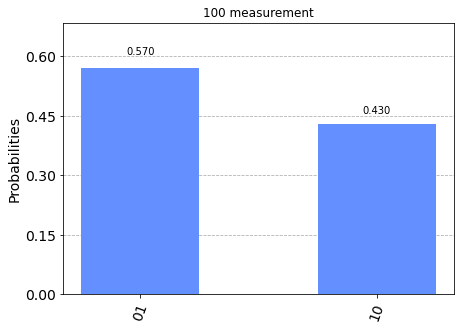

In [12]:
plot_histogram(counts, title="100 measurement")

1000 measurements

In [13]:
num_shots = 1000
counts, loss = optimize_quantum_circuit() 
losses.append(loss)

Target Distribution: [0.  0.5 0.5 0. ]
Last Measured Distribution: [0.005 0.484 0.501 0.01 ]
Output Error (Manhattan Distance): 0.09200000000000003
Parameters Found: [1.59396315 3.33321888]
Number of Measurement: 1000


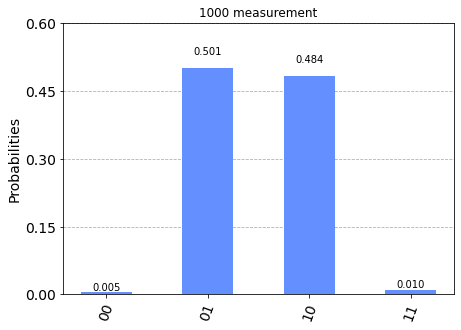

In [14]:
plot_histogram(counts, title="1000 measurement")

loss plot

<BarContainer object of 4 artists>

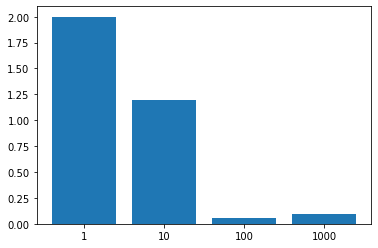

In [15]:
plt.bar(["1", "10", "100", "1000"], losses)

**Bouns:**

We can use quantum phase estimation algorithm to deferentate between |0> + $e^{i\phi}$ |1> and |0> + |1>